In [7]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout, BatchNormalization, Reshape, Conv2D, Add, Activation, Multiply, Concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


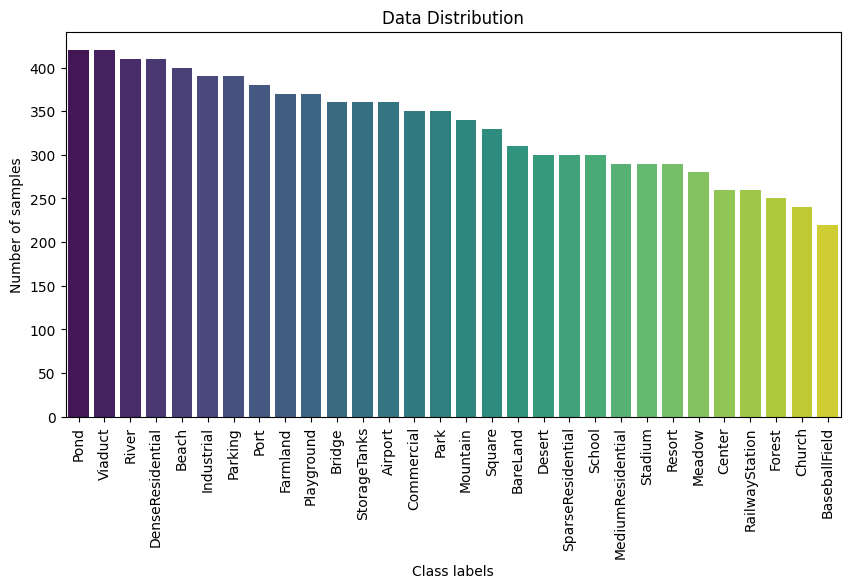

In [8]:
directory = '/kaggle/input/aid-scene-classification-datasets/AID'

labels = []
for subdir in os.listdir(directory):
    if os.path.isdir(os.path.join(directory, subdir)):
        for file in os.listdir(os.path.join(directory, subdir)):
            labels.append(subdir)

label_counts = pd.Series(labels).value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Data Distribution")
plt.ylabel("Number of samples")
plt.xlabel("Class labels")
plt.xticks(rotation=90)
plt.show()


In [9]:
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1
random_seed = 42

train_data = []
validation_data = []
test_data = []

for subdir in os.listdir(directory):
    if os.path.isdir(os.path.join(directory, subdir)):
        files = os.listdir(os.path.join(directory, subdir))
        train_files, temp_files = train_test_split(files, train_size=train_ratio, random_state=random_seed)
        validation_files, test_files = train_test_split(temp_files, train_size=validation_ratio / (validation_ratio + test_ratio), random_state=random_seed)
        train_data += [(os.path.join(directory, subdir, f), subdir) for f in train_files]
        validation_data += [(os.path.join(directory, subdir, f), subdir) for f in validation_files]
        test_data += [(os.path.join(directory, subdir, f), subdir) for f in test_files]


In [10]:
train_df = pd.DataFrame(train_data, columns=['filename', 'class'])
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_dataframe(train_df, x_col='filename', y_col='class', target_size=(224, 224), batch_size=32, class_mode='sparse')


Found 8000 validated image filenames belonging to 30 classes.


In [11]:
validation_df = pd.DataFrame(validation_data, columns=['filename', 'class'])
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(validation_df, x_col='filename', y_col='class', target_size=(224, 224), batch_size=32, class_mode='sparse')


Found 1000 validated image filenames belonging to 30 classes.


In [12]:
test_df = pd.DataFrame(test_data, columns=['filename', 'class'])
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test_df, x_col='filename', y_col='class', target_size=(224, 224), batch_size=32, class_mode='sparse', shuffle=False)


Found 1000 validated image filenames belonging to 30 classes.


In [13]:
class SpatialAttention(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.conv = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)

    def call(self, inputs, **kwargs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool, max_pool])
        return Multiply()([inputs, self.conv(concat)])


In [14]:
def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

def cbam_block(cbam_feature, ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = SpatialAttention()(cbam_feature)
    return cbam_feature


In [15]:
# Load the MobileNetV2 model
base_model = MobileNetV2(include_top=False, weights='/kaggle/input/imagenet/tensorflow1/in2/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5', input_shape=(224, 224, 3))

# Add CBAM to MobileNetV2
x = base_model.output
x = Conv2D(1280, (1, 1), padding='same', activation='relu')(x)  # Adjusting the dimensions
x = cbam_block(x)
x = GlobalAveragePooling2D()(x)
x = Dense(30, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


In [43]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 952s 4s/step - accuracy: 0.8641 - loss: 0.4439 - val_accuracy: 0.0960 - val_loss: 9.7079 - learning_rate: 0.0010
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 942s 4s/step - accuracy: 0.8821 - loss: 0.3932 - val_accuracy: 0.1990 - val_loss: 11.3334 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 961s 4s/step - accuracy: 0.8893 - loss: 0.3497 - val_accuracy: 0.2410 - val_loss: 5.8239 - learning_rate: 0.0010
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 974s 4s/step - accuracy: 0.9044 - loss: 0.3263 - val_accuracy: 0.1550 - val_loss: 12.3467 - learning_rate: 0.0010
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 982s 4s/step - accuracy: 0.9102 - loss: 0.2836 - val_accuracy: 0.1880 - val_loss: 12.6624 - learning_rate: 0.0010
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 954s 4s/step - accuracy: 0.9115 - loss: 0.2896 - val_accuracy: 0.1950 - val_loss: 8.6831 - learning_rate: 0.0010
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 974s 4s/step - accuracy: 0.9090 - loss:

In [44]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 699ms/step - accuracy: 0.9511 - loss: 0.2921
Test Loss: 0.2473006695508957
Test Accuracy: 0.9539999961853027


In [45]:
y_true = test_generator.classes
y_pred_cbam = np.argmax(model.predict(test_generator), axis=-1)
conf_matrix_cbam = confusion_matrix(y_true, y_pred_cbam)
class_report_cbam = classification_report(y_true, y_pred_cbam, target_names=list(test_generator.class_indices.keys()))

print('CBAM Model - Confusion Matrix')
print(conf_matrix_cbam)
print('CBAM Model - Classification Report')
print(class_report_cbam)


32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 743ms/step
CBAM Model - Confusion Matrix
[[36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 1 29  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 1  0  0  0  0 24  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  3  0  0  0  0  0  0  0  0  1  0  0
   0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  1 36  0  0  0  3  0  1  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [47]:
# Save the model
model.save('cbam_mobilenetv2_model.h5')

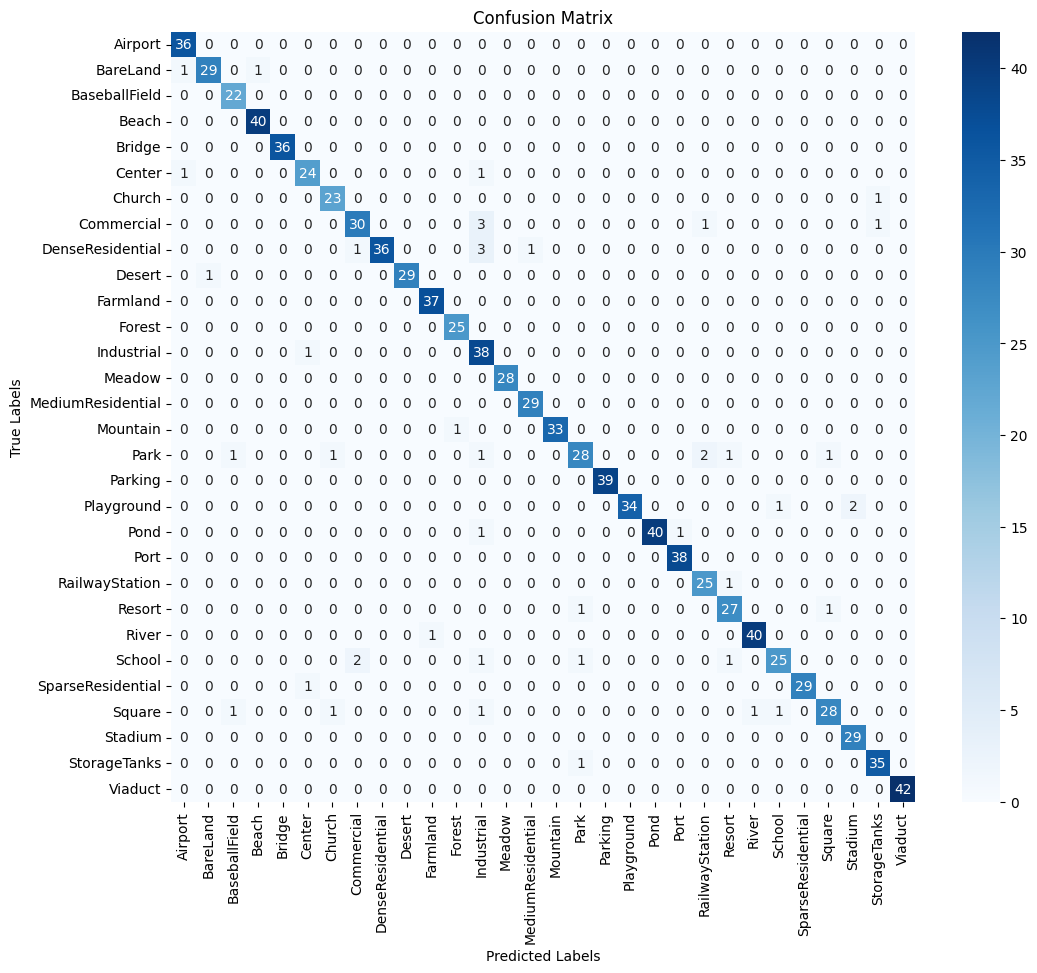

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred_cbam are already defined
conf_matrix_cbam = confusion_matrix(y_true, y_pred_cbam)

# Plotting the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_cbam, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

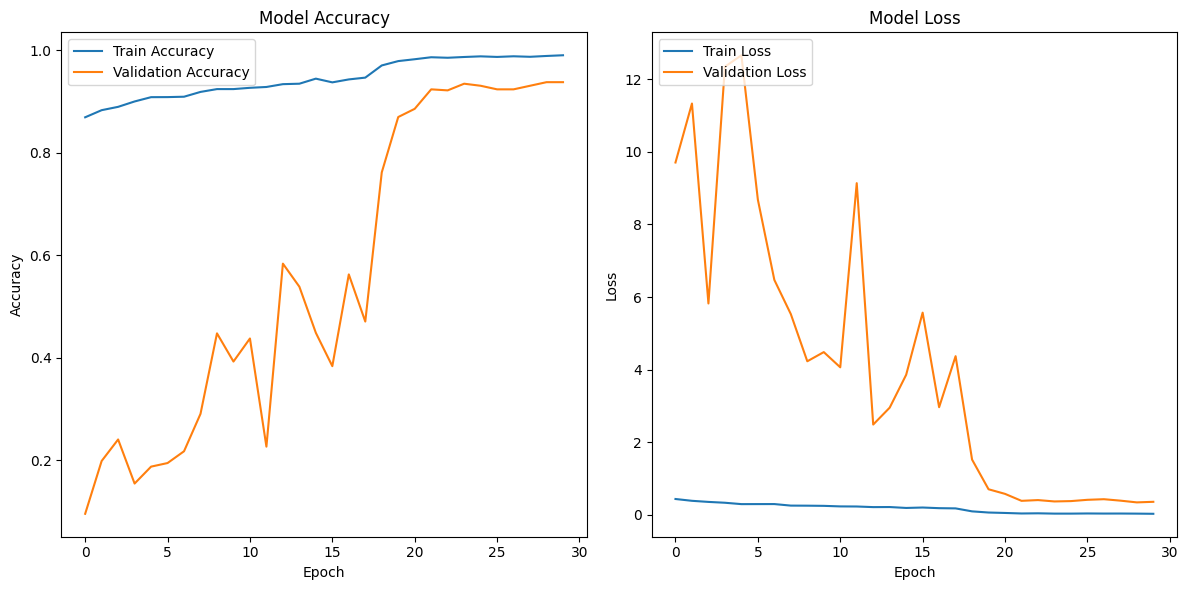

In [50]:
import matplotlib.pyplot as plt

# Assuming `history` is the History object returned by `model.fit`
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 666ms/step


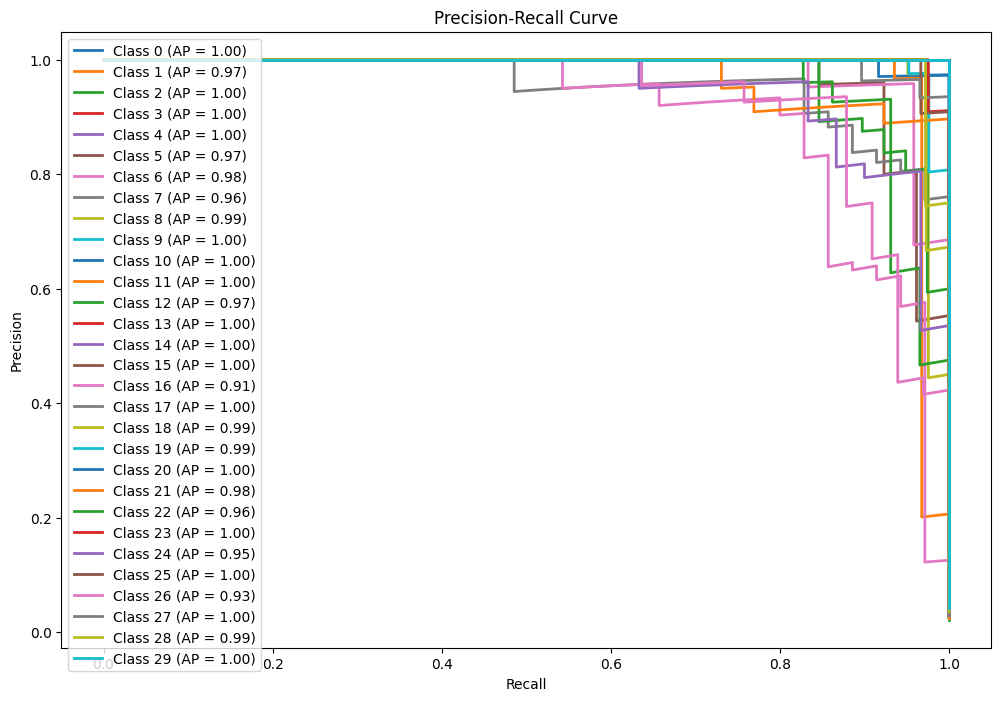

In [51]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Assuming y_true and y_pred_cbam are already defined

# Convert y_true to categorical format if not already in that format
y_true_categorical = tf.keras.utils.to_categorical(y_true, num_classes=30)

# Get the predicted probabilities for each class
y_pred_prob = model.predict(test_generator)

# Calculate the precision and recall for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(30):  # Assuming 30 classes
    precision[i], recall[i], _ = precision_recall_curve(y_true_categorical[:, i], y_pred_prob[:, i])
    average_precision[i] = average_precision_score(y_true_categorical[:, i], y_pred_prob[:, i])

# Plot the PR curve for each class
plt.figure(figsize=(12, 8))
for i in range(30):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 655ms/step


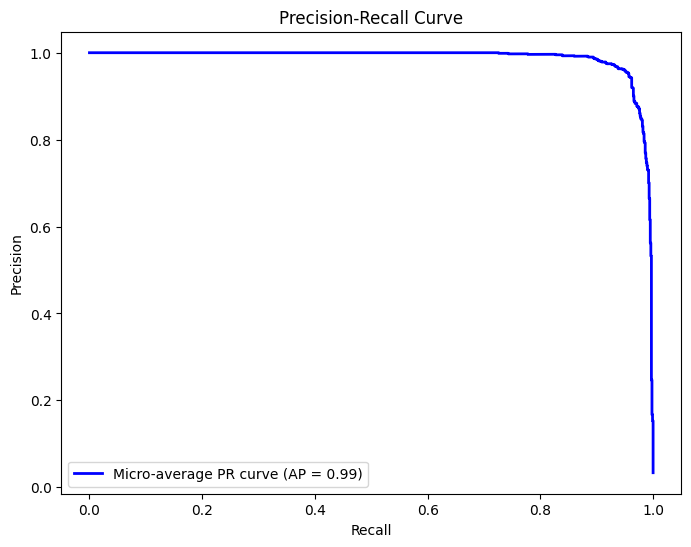

In [53]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Convert y_true to categorical format if not already in that format
y_true_categorical = tf.keras.utils.to_categorical(y_true, num_classes=30)

# Get the predicted probabilities for each class
y_pred_prob = model.predict(test_generator)

# Compute micro-average precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(y_true_categorical.ravel(), y_pred_prob.ravel())
average_precision = average_precision_score(y_true_categorical, y_pred_prob, average="micro")

# Plot the micro-average PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'Micro-average PR curve (AP = {average_precision:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()
